In [1]:
# import Pkg
# Pkg.develop(path=pwd())

In [1]:
using Revise
using MathOptInterface
using SDDP
using Random
using Plots
using Gurobi
using StatsPlots
using Statistics
using Printf
const GRB_ENV = Gurobi.Env()
optimizer=() -> Gurobi.Optimizer(GRB_ENV)
using Serialization

Set parameter Username
Set parameter LicenseID to value 2658456
Academic license - for non-commercial use only - expires 2026-04-28


In [2]:
shift_list=[SDDP.no_shift, SDDP.shift_random, SDDP.shift_update_random, SDDP.shift_random_forward, SDDP.shift_update_random_forward]
labels=Dict(SDDP.no_shift => "SDDP", 
            SDDP.shift_random=> "RVSDDP",
            SDDP.shift_update_random=> "RVSDDP-U",
            SDDP.shift_random_forward=> "RVSDDP-F",
            SDDP.shift_update_random_forward=> "RVSDDP-FU")

colors=Dict(SDDP.no_shift => :black, 
            SDDP.shift_random=> :red,
            SDDP.shift_update_random=> :green,
            SDDP.shift_random_forward=> :red,
            SDDP.shift_update_random_forward=> :green)

line_styles=Dict(SDDP.no_shift => :solid, 
            SDDP.shift_random=> :dash,
            SDDP.shift_update_random=> :dash,
            SDDP.shift_random_forward=> :solid,
            SDDP.shift_update_random_forward=> :solid)

Dict{Function, Symbol} with 5 entries:
  shift_random                => :dash
  no_shift                    => :solid
  shift_update_random_forward => :solid
  shift_update_random         => :dash
  shift_random_forward        => :solid

In [81]:
beta=0.99
folder = "results_ICSP/"
# folder = "results_ICSP/beta$beta/"
# cuts = Dict(shift => sum(Serialization.deserialize(folder*"$(shift)/active_cuts_44.jls"))  for shift in shift_list)
# oos = Dict(shift => mean(Serialization.deserialize(folder*"$(shift)/oos_141/oos_1-3000.jls")[1])  for shift in shift_list)
times = Dict(shift => mean([Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/time.jls") for k in 6:9])  for shift in shift_list)

Dict{Function, Float64} with 5 entries:
  shift_random                => 44310.0
  no_shift                    => 22962.1
  shift_update_random_forward => 43555.2
  shift_update_random         => 47403.8
  shift_random_forward        => 32711.6

In [82]:
beta=0.99
folder = "results_ICSP/"
oos = Dict(shift => [mean([Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/oos_$iter/oos_1-100.jls")[1] for k in 1:6]) for iter in [44,63,77,89,100,109, 118,126,134,141]]  for shift in shift_list)

Dict{Function, Vector{Vector{Float64}}} with 5 entries:
  shift_random                => [[2.79311e6, 3.28367e6, 2.63422e6, 2.99477e6, …
  no_shift                    => [[2.84797e6, 3.50835e6, 2.77359e6, 3.14298e6, …
  shift_update_random_forward => [[2.76192e6, 3.22789e6, 2.58278e6, 2.93059e6, …
  shift_update_random         => [[2.76385e6, 3.20531e6, 2.58247e6, 2.94445e6, …
  shift_random_forward        => [[2.76617e6, 3.24715e6, 2.59796e6, 2.96435e6, …

Graphique enregistré sous : graph/0.99_costs_iterations.png


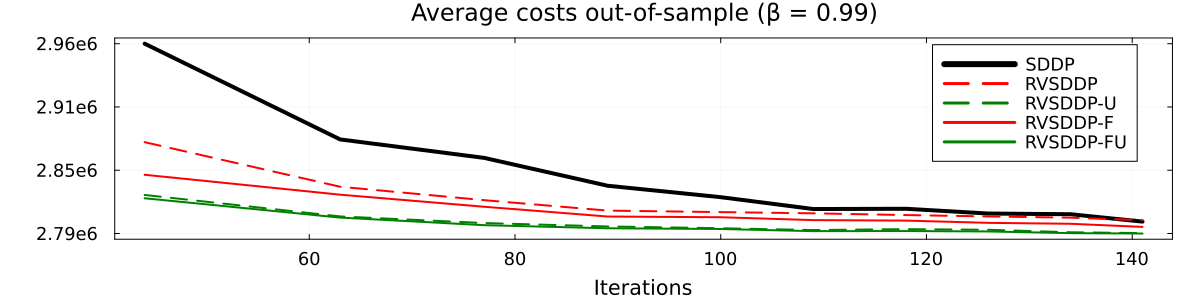

In [84]:
iterations=[44,63,77,89,100,109, 118, 126, 134, 141]

# Configuration des tailles de police
font_size_axes = 14        # Titres des axes (xlabel, ylabel)
font_size_legend = 12      # Légende
font_size_title = 16       # Titre principal
font_size_ticks = 12       # Étiquettes des axes (valeurs numériques)

# Calcul des données pour déterminer la plage de l'axe Y
data_ref = [mean(oos[SDDP.no_shift][k]) for k in 1:length(iterations)]
all_data = [data_ref]
for shift in shift_list[2:end]
    push!(all_data, [mean(oos[shift][k]) for k in 1:length(iterations)])
end
y_min = minimum(vcat(all_data...))
y_max = maximum(vcat(all_data...))
# Création de 4 graduations uniformément réparties
y_ticks = range(y_min, y_max, length=4)

# Fonction de formatage pour notation scientifique propre
function format_scientific(x)
    if abs(x) >= 1e6 || abs(x) <= 1e-3
        # Notation scientifique pour les très grandes ou très petites valeurs
        exp_val = floor(Int, log10(abs(x)))
        mantissa = x / (10.0^exp_val)
        return @sprintf("%.2fe%d", mantissa, exp_val)
    else
        # Format normal pour les valeurs modérées
        return string(round(x, digits=2))
    end
end

p=plot(iterations, data_ref, 
    label="SDDP", 
    linestyle=line_styles[SDDP.no_shift], 
    color=colors[SDDP.no_shift], 
    linewidth=4,
    size=(1200, 300),
    # Configuration des titres et tailles de police
    xlabel="Iterations",
    # ylabel="Average costs out-of-sample",
    title="Average costs out-of-sample (β = $beta)",
    titlefontsize=font_size_title,
    guidefontsize=font_size_axes,
    legendfontsize=font_size_legend,
    tickfontsize=font_size_ticks,
    # Formatage de l'axe Y avec notation scientifique propre
    yformatter=format_scientific,
    # Limitation du nombre de graduations à 4
    yticks=y_ticks,
    # Options supplémentaires pour améliorer la lisibilité
    grid=true,
    gridwidth=1,
    gridcolor=:lightgray,
    framestyle=:box,
    # Ajustement des marges pour que les titres soient visibles
    margin=5Plots.mm,
    left_margin=8Plots.mm,
    bottom_margin=8Plots.mm,
    top_margin=5Plots.mm,
    right_margin=5Plots.mm)

for shift in shift_list[2:end]
    plot!(iterations, [mean(oos[shift][k]) for k in 1:length(iterations)], 
        label=labels[shift], 
        linestyle=line_styles[shift], 
        color=colors[shift], 
        linewidth=2)
end

# Enregistrement du graphique
filename = "graph/$(beta)_costs_iterations.png"
savefig(p, filename)
println("Graphique enregistré sous : $filename")

p

In [85]:
beta=0.99
iterations=[44,63,77,89,100,109, 118, 126, 134, 141]
folder = "results_ICSP/"
cuts = Dict(shift => [mean([sum(Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/active_cuts_$iter.jls")) for k in 1:6]) for iter in [44,63,77,89,100,109, 118,126,134,141]]  for shift in shift_list)

Dict{Function, Vector{Float64}} with 5 entries:
  shift_random                => [930.5, 1479.5, 1859.33, 2398.67, 2805.17, 282…
  no_shift                    => [738.167, 1062.5, 1390.33, 1770.17, 2006.33, 2…
  shift_update_random_forward => [1887.5, 3700.5, 5520.5, 7088.83, 9259.33, 107…
  shift_update_random         => [1964.0, 3922.33, 5327.67, 6778.0, 8875.67, 10…
  shift_random_forward        => [1675.67, 3006.0, 3967.17, 5065.33, 6163.83, 6…

Graphique enregistré sous : graph/0.99_cut_iterations.png


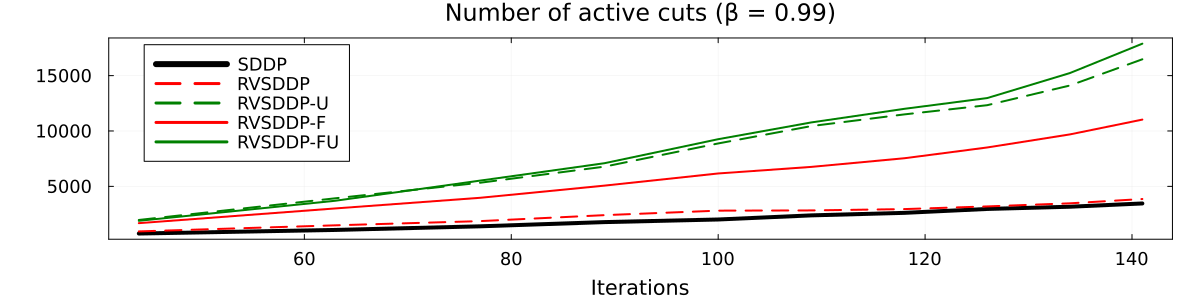

In [87]:
# Configuration des tailles de police
font_size_axes = 14        # Titres des axes (xlabel, ylabel)
font_size_legend = 12      # Légende
font_size_title = 16       # Titre principal
font_size_ticks = 12       # Étiquettes des axes (valeurs numériques)

# Calcul des données pour déterminer la plage de l'axe Y
data_ref = [cuts[SDDP.no_shift][k] for k in 1:length(iterations)]
all_data = [data_ref]
for shift in shift_list[2:end]
    push!(all_data, [cuts[shift][k] for k in 1:length(iterations)])
end
y_min = minimum(vcat(all_data...))
y_max = maximum(vcat(all_data...))
# Graduations spécifiques pour l'axe Y
y_ticks = [0, 5000, 10000, 15000, 20000]

# Fonction de formatage pour notation scientifique propre
function format_scientific(x)
    if abs(x) >= 1e6 || abs(x) <= 1e-3
        # Notation scientifique pour les très grandes ou très petites valeurs
        exp_val = floor(Int, log10(abs(x)))
        mantissa = x / (10.0^exp_val)
        return @sprintf("%.2fe%d", mantissa, exp_val)
    else
        # Format normal pour les valeurs modérées
        return string(Int64(round(x)))
    end
end

p=plot(iterations, data_ref, 
    label="SDDP", 
    linestyle=line_styles[SDDP.no_shift], 
    color=colors[SDDP.no_shift], 
    linewidth=4,
    size=(1200, 300),
    # Configuration des titres et tailles de police
    xlabel="Iterations",
    title="Number of active cuts (β = $beta)",
    titlefontsize=font_size_title,
    guidefontsize=font_size_axes,
    legendfontsize=font_size_legend,
    tickfontsize=font_size_ticks,
    # Formatage de l'axe Y avec notation scientifique propre
    # yformatter=format_scientific,
    # Limitation du nombre de graduations à 4
    yticks=y_ticks,
    # Options supplémentaires pour améliorer la lisibilité
    grid=true,
    gridwidth=1,
    gridcolor=:lightgray,
    framestyle=:box,
    # Ajustement des marges pour que les titres soient visibles
    margin=5Plots.mm,
    left_margin=8Plots.mm,
    bottom_margin=8Plots.mm,
    top_margin=5Plots.mm,
    right_margin=5Plots.mm)

for shift in shift_list[2:end]
    plot!(iterations, [cuts[shift][k] for k in 1:length(iterations)], 
        label=labels[shift], 
        linestyle=line_styles[shift], 
        color=colors[shift], 
        linewidth=2)
end

# Enregistrement du graphique
filename = "graph/$(beta)_cut_iterations.png"
savefig(p, filename)
println("Graphique enregistré sous : $filename")

p
# data_ref

In [71]:
beta_list = [0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
kmax = Dict(beta => 10 for beta in beta_list)
kmax[0.8] = 9
kmax[0.7] = 6
iter=141
folder = "results_ICSP/"
shiftref=SDDP.no_shift
oosref = Dict(beta => [mean(Serialization.deserialize(folder*"$k/beta_$beta/$(shiftref)/oos_$iter/oos_1-100.jls")[1]) for k in 1:kmax[beta]] for beta in beta_list)
oos = Dict(shift => [mean([100*(oosref[beta][k]-mean(Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/oos_$iter/oos_1-100.jls")[1]))/oosref[beta][k] for k in 1:kmax[beta]]) for beta in beta_list] for shift in shift_list)
oos = Dict(shift => [mean([mean(Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/oos_$iter/oos_1-100.jls")[1]) for k in 1:kmax[beta]]) for beta in beta_list] for shift in shift_list)

Dict{Function, Vector{Float64}} with 5 entries:
  shift_random                => [22970.7, 55890.5, 1.84843e5, 4.7869e5, 2.8032…
  no_shift                    => [22849.7, 55523.4, 1.83878e5, 4.77191e5, 2.802…
  shift_update_random_forward => [22849.0, 55580.2, 1.83765e5, 476753.0, 2.7912…
  shift_update_random         => [22864.9, 55597.9, 1.83794e5, 4.7675e5, 2.7913…
  shift_random_forward        => [22964.1, 55788.6, 1.84385e5, 4.7777e5, 2.7972…

In [73]:
[(shift, oos[shift][5]) for shift in shift_list]

5-element Vector{Tuple{Function, Float64}}:
 (SDDP.no_shift, 2.8023359403070477e6)
 (SDDP.shift_random, 2.8032732043999275e6)
 (SDDP.shift_update_random, 2.791304525875182e6)
 (SDDP.shift_random_forward, 2.79728011616651e6)
 (SDDP.shift_update_random_forward, 2.791273046327013e6)

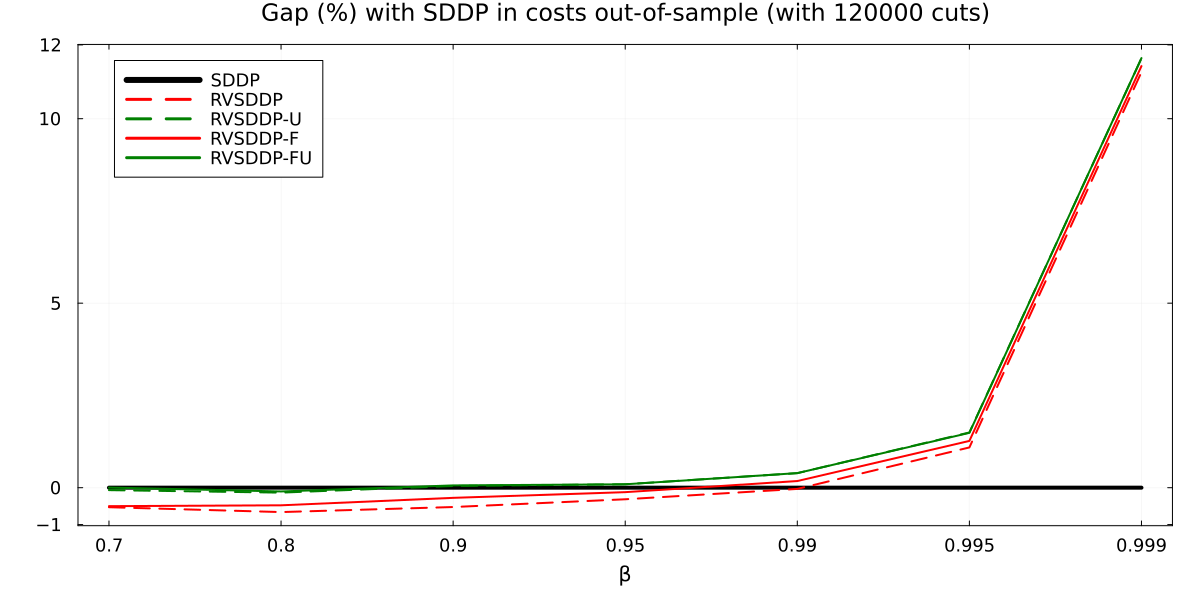

In [68]:
# Configuration des tailles de police
font_size_axes = 14        # Titres des axes (xlabel, ylabel)
font_size_legend = 12      # Légende
font_size_title = 16       # Titre principal
font_size_ticks = 12       # Étiquettes des axes (valeurs numériques)

# Calcul des données pour déterminer la plage de l'axe Y
data_ref = [oos[SDDP.no_shift][k] for k in 1:length(beta_list)]
all_data = [data_ref]
for shift in shift_list[2:end]
    push!(all_data, [oos[shift][k] for k in 1:length(beta_list)])
end
y_min = minimum(vcat(all_data...))
y_max = maximum(vcat(all_data...))
y_ticks = [-1, 0.0, 5, 10,12]

# Pour une échelle logarithmique, on peut choisir des ticks intermédiaires
xticks = [1,2,3,4,5,6,7]
xticklabels = ["0.7", "0.8", "0.9", "0.95", "0.99", "0.995", "0.999"]

function format_scientific(x)
    if abs(x) >= 1e6 || abs(x) <= 1e-3
        exp_val = floor(Int, log10(abs(x)))
        mantissa = x / (10.0^exp_val)
        return @sprintf("%.2fe%d", mantissa, exp_val)
    else
        return string(round(x, digits=2))
    end
end

p=plot(xticks, data_ref, 
    label="SDDP", 
    linestyle=line_styles[SDDP.no_shift], 
    color=colors[SDDP.no_shift], 
    linewidth=4,
    size=(1200, 600),
    xlabel="β",
    title="Gap (%) with SDDP in costs out-of-sample (with 120000 cuts)",
    titlefontsize=font_size_title,
    guidefontsize=font_size_axes,
    legendfontsize=font_size_legend,
    tickfontsize=font_size_ticks,
    yticks=y_ticks,
    xticks=(xticks, xticklabels),
    grid=true,
    gridwidth=1,
    gridcolor=:lightgray,
    framestyle=:box,
    margin=5Plots.mm,
    left_margin=8Plots.mm,
    bottom_margin=8Plots.mm,
    top_margin=5Plots.mm,
    right_margin=5Plots.mm)

for shift in shift_list[2:end]
    plot!(xticks, [oos[shift][k] for k in 1:length(beta_list)], 
        label=labels[shift], 
        linestyle=line_styles[shift], 
        color=colors[shift], 
        linewidth=2)
end

# filename = "graph/gap.png"
# savefig(p, filename)
# println("Graphique enregistré sous : $filename")

p

In [45]:
beta_list = [0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 1.0]
kmax = Dict(beta => 10 for beta in beta_list)
kmax[0.8] = 9
kmax[0.7] = 6
kmax[1.0] = 6
iter=141
folder = "results_ICSP/"
shiftref=SDDP.no_shift
# cuts = Dict(shift => [sum(Serialization.deserialize(folder*"$beta/$(shift)/active_cuts_$iter.jls")) for beta in beta_list] for shift in shift_list[2:end])
cuts = Dict(shift => [mean([sum(Serialization.deserialize(folder*"$k/beta_$beta/$(shift)/active_cuts_$iter.jls")) for k in 1:kmax[beta]]) for beta in beta_list] for shift in shift_list)

Dict{Function, Vector{Float64}} with 5 entries:
  shift_random                => [16313.2, 10052.7, 5873.9, 4717.1, 4062.4, 413…
  no_shift                    => [41650.7, 32630.1, 20019.0, 11596.2, 3451.1, 2…
  shift_update_random_forward => [40933.0, 34225.2, 33777.1, 28155.5, 17444.0, …
  shift_update_random         => [40963.8, 34088.4, 32226.2, 27108.9, 16841.6, …
  shift_random_forward        => [28418.3, 20883.7, 18898.6, 16582.0, 11783.6, …

In [74]:
[(shift, cuts[shift][5]) for shift in shift_list]

5-element Vector{Tuple{Function, Float64}}:
 (SDDP.no_shift, 3451.1)
 (SDDP.shift_random, 4062.4)
 (SDDP.shift_update_random, 16841.6)
 (SDDP.shift_random_forward, 11783.6)
 (SDDP.shift_update_random_forward, 17444.0)

Graphique enregistré sous : graph/cuts_beta.png


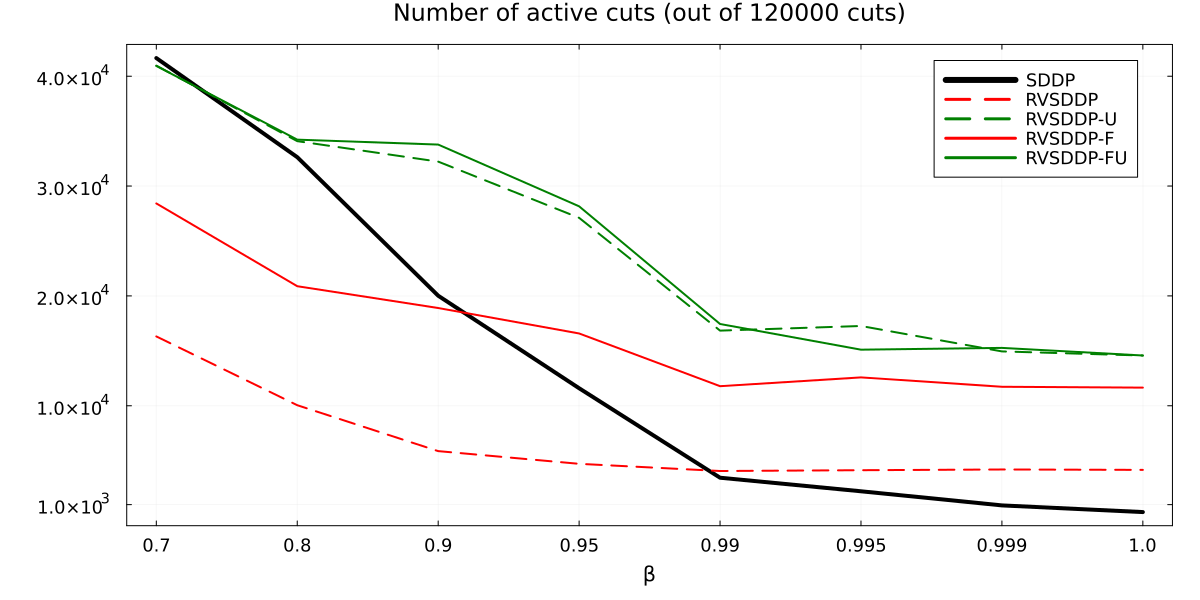

In [61]:
# Configuration des tailles de police
font_size_axes = 14        # Titres des axes (xlabel, ylabel)
font_size_legend = 12      # Légende
font_size_title = 16       # Titre principal
font_size_ticks = 12       # Étiquettes des axes (valeurs numériques)

# Calcul des données pour déterminer la plage de l'axe Y
data_ref = [cuts[SDDP.no_shift][k] for k in 1:length(beta_list)]
all_data = [data_ref]
for shift in shift_list[2:end]
    push!(all_data, [cuts[shift][k] for k in 1:length(beta_list)])
end
y_min = minimum(vcat(all_data...))
y_max = maximum(vcat(all_data...))
# Graduations spécifiques pour l'axe Y
y_ticks = [1000, 10000, 20000, 30000,40000]

xticks = [1,2,3,4,5,6,7,8]
xticklabels = ["0.7", "0.8", "0.9", "0.95", "0.99", "0.995", "0.999", "1.0"]

# Fonction de formatage pour notation scientifique propre
function format_scientific(x)
    if abs(x) >= 1e6 || abs(x) <= 1e-3
        # Notation scientifique pour les très grandes ou très petites valeurs
        exp_val = floor(Int, log10(abs(x)))
        mantissa = x / (10.0^exp_val)
        return @sprintf("%.2fe%d", mantissa, exp_val)
    else
        # Format normal pour les valeurs modérées
        return string(Int64(round(x)))
    end
end

p=plot(xticks, data_ref, 
    label="SDDP", 
    linestyle=line_styles[SDDP.no_shift], 
    color=colors[SDDP.no_shift], 
    linewidth=4,
    size=(1200, 600),
    # Configuration des titres et tailles de police
    xlabel="β",
    title="Number of active cuts (out of 120000 cuts)",
    titlefontsize=font_size_title,
    guidefontsize=font_size_axes,
    legendfontsize=font_size_legend,
    tickfontsize=font_size_ticks,
    # Formatage de l'axe Y avec notation scientifique propre
    # yformatter=format_scientific,
    xticks=(1:8, xticklabels),
    # Limitation du nombre de graduations à 4
    yticks=y_ticks,
    # Options supplémentaires pour améliorer la lisibilité
    grid=true,
    gridwidth=1,
    gridcolor=:lightgray,
    framestyle=:box,
    # Ajustement des marges pour que les titres soient visibles
    margin=5Plots.mm,
    left_margin=8Plots.mm,
    bottom_margin=8Plots.mm,
    top_margin=5Plots.mm,
    right_margin=5Plots.mm
)

for shift in shift_list[2:end]
    plot!(1:8, [cuts[shift][k] for k in 1:length(beta_list)], 
        label=labels[shift], 
        linestyle=line_styles[shift], 
        color=colors[shift], 
        linewidth=2)
end

# Enregistrement du graphique
filename = "graph/cuts_beta.png"
savefig(p, filename)
println("Graphique enregistré sous : $filename")

p

In [7]:
0.95^(12*20)
# Random.seed!(2)
# rand()

4.50469373299378e-6

In [15]:
time_dict  = Dict(shift => Serialization.deserialize("results/10000cutsP1/$(shift)/time.jls")  for shift in shift_list)
N=11
K=30
for i in 1:N
    println("Time for $(labels[i]): ", time_dict[shift_list[i]])
end
println("\n 1000 cuts on each node = 12000 cuts")
active_cuts_dict  = Dict(shift => Serialization.deserialize("results/10000cutsP1/$(shift)/active_cuts.jls")  for shift in shift_list)
for i in 1:N
    println("Total Active cuts for $(labels[i]): ", sum(active_cuts_dict[shift_list[i]]))
end
println("\n ")
for i in 1:N
    println("Active cuts for $(labels[i]): ", active_cuts_dict[shift_list[i]])
end
println("\n ")
Cost=[Serialization.deserialize("results/10000cutsP1/oos/oos$j.jls") for j in 1:K]
Cost=[Dict(string(shift) => mean(value)  for (shift, value) in Cost[j]) for j in 1:K]
for i in 1:N
    println("mean Cost for $(labels[i]): ", mean([Cost[j][labels[i]] for j in 1:K]))
end

Time for current_shift: 30996.43334698677
Time for current_shift_update: 34966.50490617752
Time for no_shift: 26415.800174951553
Time for current_shift_update_warmstart: 60805.949228048325
Time for current_shift_warmstart: 59422.87319397926
Time for random_shift: 49866.368686914444
Time for random_shift_update: 52276.58822321892
Time for random_current_shift: 37634.24206805229
Time for random_current_shift_update: 48430.907937049866
Time for random_current_shift_warmstart: 52786.734431028366
Time for random_current_shift_update_warmstart: 56640.477715969086

 1000 cuts on each node = 12000 cuts
Total Active cuts for current_shift: 5393
Total Active cuts for current_shift_update: 10739
Total Active cuts for no_shift: 3672
Total Active cuts for current_shift_update_warmstart: 24592
Total Active cuts for current_shift_warmstart: 9512
Total Active cuts for random_shift: 4996
Total Active cuts for random_shift_update: 20394
Total Active cuts for random_current_shift: 14162
Total Active cuts

In [ ]:
# Configuration des tailles de police
font_size_axes = 14        # Titres des axes (xlabel, ylabel)
font_size_legend = 12      # Légende
font_size_title = 16       # Titre principal
font_size_ticks = 12       # Étiquettes des axes (valeurs numériques)
    sheet["B1"] = "Time (s)"
# Calcul des données pour déterminer la plage de l'axe Y
data_ref = [oos[SDDP.shift_random][k] for k in 1:length(beta_list)]
all_data = [data_ref])"] = time_dict[shift_list[i]]
for shift in shift_list[3:end]
    push!(all_data, [oos[shift][k] for k in 1:length(beta_list)])
end # Feuille 2: Total Active Cuts
y_min = minimum(vcat(all_data...))ve Cuts")
y_max = maximum(vcat(all_data...))
# Création de 4 graduations uniformément réparties
y_ticks = range(y_min, y_max, length=4)
x_ticks = beta_list
        sheet["A$(i+1)"] = labels[i]
# Fonction de formatage pour notation scientifique propret[i]])
function format_scientific(x)
    if abs(x) >= 1e6 || abs(x) <= 1e-3
        # Notation scientifique pour les très grandes ou très petites valeurs
        exp_val = floor(Int, log10(abs(x)))
        mantissa = x / (10.0^exp_val)
        return @sprintf("%.2fe%d", mantissa, exp_val)
    elset["B1"] = "Mean Cost"
        # Format normal pour les valeurs modérées
        return string(round(x, digits=2))i]] for j in 1:K])
    end sheet["A$(i+1)"] = labels[i]
end     sheet["B$(i+1)"] = mean_cost
    end
p=plot(beta_list, data_ref,     label="SDDP",     linestyle=line_styles[SDDP.shift_random],     color=colors[SDDP.shift_random],     linewidth=4,    size=(1200, 300),    # Configuration des titres et tailles de police    xlabel="Iterations",    # ylabel="Average costs out-of-sample",    title="Average costs out-of-sample (β = $beta)",    titlefontsize=font_size_title,    guidefontsize=font_size_axes,    legendfontsize=font_size_legend,    tickfontsize=font_size_ticks,    # Formatage de l'axe Y avec notation scientifique propre    yformatter=format_scientific,    # Échelle logarithmique pour l'axe X    xscale=:log10,    # Limitation du nombre de graduations à 4    yticks=y_ticks,    xticks=x_ticks,    # Options supplémentaires pour améliorer la lisibilité    grid=true,    gridwidth=1,    gridcolor=:lightgray,    framestyle=:box,    # Ajustement des marges pour que les titres soient visibles    margin=5Plots.mm,    left_margin=8Plots.mm,    bottom_margin=8Plots.mm,    top_margin=5Plots.mm,    right_margin=5Plots.mm)for shift in shift_list[3:end]    plot!(beta_list, [oos[shift][k] for k in 1:length(beta_list)],         label=labels[shift],         linestyle=line_styles[shift],         color=colors[shift],         linewidth=2)end# Enregistrement du graphique# filename = "graph/$(beta)_costs_iterations.png"# savefig(p, filename)# println("Graphique enregistré sous : $filename")

p

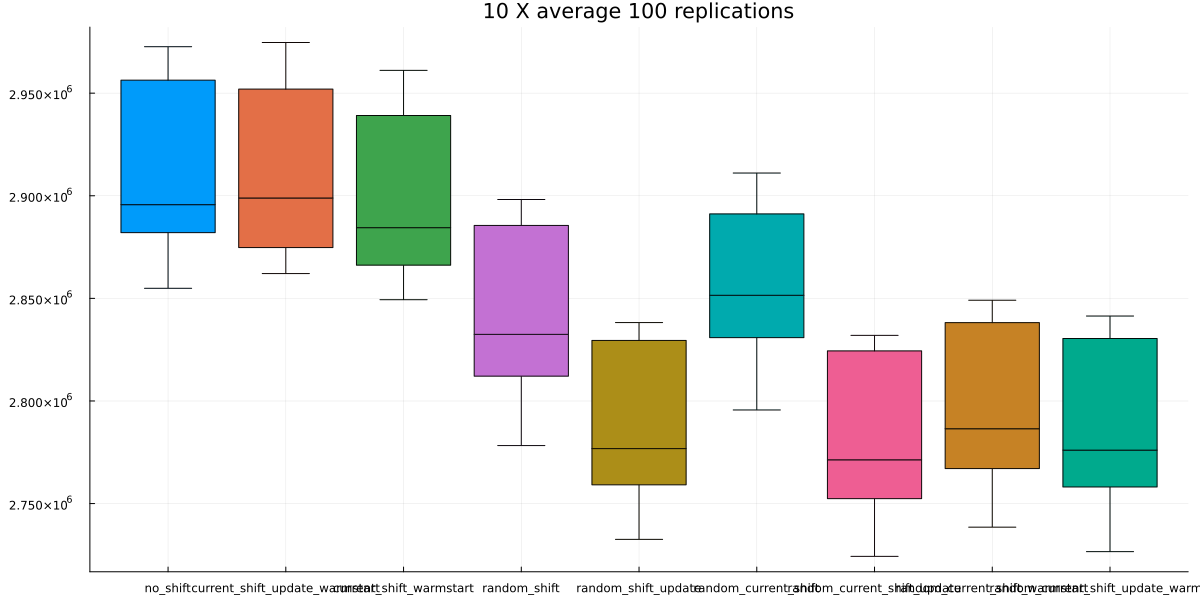

In [24]:
# H=[mean.(Serialization.deserialize("results/141_without/oos/oos$i.jls")) for i in 1:30]
K=3

mean_shift=[[Cost[i][labels[k]] for i in 1:10] for k in K:N]

valeurs = vcat(mean_shift)

p=boxplot(valeurs, xticks = (1:N-K+1, labels[K:N]), title="10 X average 100 replications", legend=false, size=(1200, 600))

In [17]:
model_dict = Dict(shift => Serialization.deserialize("results/10000cutsP1/$(shift)/model.jls") for shift in shift_list)
# cuts_dict  = Dict(shift => Serialization.deserialize("results/141_without/$(shift)/Cuts.jls")  for shift in shift_list)
# time_dict  = Dict(shift => Serialization.deserialize("results/141_without/$(shift)/time.jls")  for shift in shift_list)

for shift in shift_list
    for i in 1:12
        set_optimizer(model_dict[shift][i].value_function.model, optimizer)
        set_optimizer(model_dict[shift][i].subproblem, optimizer)
    end
end

In [19]:
for shift in shift_list
    for i in 1:12
        println("Min for "*string(shift)*" :", SDDP.compute_inf_V(model_dict[shift][i].value_function)[1])
    end
end

Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :1.014086592476815e-10
Min for current_shift_update :4.6470750021399e-6
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for no_shift :2.330856578884622e6
Min for no_shift :2.414531611916424e6
Min for no_shift :2.4581997450983706e6
Min for no_shift :2.474746944431608e6
Min for no_shift :2.485139126354812e6
Min for no_shift :2.476874895421772e6
Min fo

In [22]:
using XLSX
XLSX.openxlsx("results2.xlsx", mode="w") do xf

    sheet = xf[1]
    sheet["A1"] = "Label"
    sheet["B1"] = "Time (s)"
    for (i,shift) in enumerate(shift_list)
        sheet["A$(i+1)"] = labels[i]
        sheet["B$(i+1)"] = SDDP.compute_inf_V(model_dict[shift][6].value_function)[1]
    end
end

In [11]:
function compare_threads(model_list, N, i)
    println(i)
    oos = Base.invokelatest(SDDP.compare_models,
        model_list;
        replications = N,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )

    println(oos)
end

function compare(shift_list)

    model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
    for model in model_list
        for i in 1:12
            set_optimizer(model[i].value_function.model, optimizer)
            set_optimizer(model[i].subproblem, optimizer)
        end
    end

    for i in 1:1
        compare_threads(model_list,10,i)
    end

end

compare (generic function with 1 method)

In [12]:
compare(shift_list)
# compare_threads(shift_list, 10, 1)

1
Any[[2.6230765122620403e6, 2.450006230266465e6, 2.1800827301597777e6, 3.0190090483876844e6, 2.552690034982523e6, 2.0522649010752295e6, 2.7615141449837727e6, 2.3635823432433773e6, 2.828973337684107e6, 2.5261292414896768e6], [2.5545512487881104e6, 2.432680955664053e6, 2.164854932872658e6, 3.0345969624791075e6, 2.4770809964531423e6, 2.0196490740971297e6, 2.738689926681199e6, 2.375202055649845e6, 2.774227722667018e6, 2.513505130619241e6], [2.5598484041514923e6, 2.4304454080185066e6, 2.1648604610114023e6, 3.016167954923674e6, 2.4796749751498797e6, 2.040450418647611e6, 2.7249286518530343e6, 2.442793310310466e6, 2.683377480751486e6, 2.5058972150496673e6], [2.529811383471636e6, 2.434026866739634e6, 2.1707260131603293e6, 3.018105900973972e6, 2.478476335786809e6, 2.0408292960509863e6, 2.741015814158697e6, 2.379813852683963e6, 2.6694415538773127e6, 2.50303302102209e6], [2.5230961826624693e6, 2.43063951091041e6, 2.1694192802864565e6, 3.026980743550354e6, 2.4764972064433657e6, 2.0251152213622525e

In [13]:
function te()
    model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
    for model in model_list
        for i in 1:12
            set_optimizer(model[i].value_function.model, optimizer)
            set_optimizer(model[i].subproblem, optimizer)
        end
    end
    oos = Base.invokelatest(SDDP.compare_models,
        model_list;
        replications = 1,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )
end
te()

5-element Vector{Any}:
 [2.0908542570076063e6]
 [2.0820286460364284e6]
 [2.0963182588555496e6]
 [2.0962740832117973e6]
 [2.0944822802495852e6]

In [14]:
model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
for model in model_list
    for i in 1:12
        set_optimizer(model[i].value_function.model, optimizer)
        set_optimizer(model[i].subproblem, optimizer)
    end
end
SDDP.compare_models(
        model_list;
        replications = 1,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )

# SDDP.compare_models(
#         [model_dict[SDDP.no_shift]];
#         replications = 1,
#         TimeHorizon = 12*10,
#         discount_factor = 0.99,
#     )

5-element Vector{Any}:
 [2.594788588853024e6]
 [2.5918108297637817e6]
 [2.601749509013383e6]
 [2.5996926327852686e6]
 [2.596346551845947e6]